#Getting started with probabilistic programming in Gamble



This document introduces the basic ideas of probabilistic programming using Gamble, and
provides lots of small examples as starting points for your own projects.  You can tweak and re-run all the code blocks.

This primary author of this introduction is Sean Stromsten (<mail>sean.stromsten@baesystems.com</mail>), who welcomes bug reports and suggestions for improvement.

## Prerequisites
This material assumes that you 
are familiar with elementary probability theory, that you
know how to program in some language, and that you are at least a little bit
familiar with the Scheme programming language.  If your probability is
rusty, there are nice reviews 
[here](http://cs229.stanford.edu/section/cs229-prob.pdf) and
[here](http://www.math.wisc.edu/~anderson/605F11/Notes/StochBioChapter2.pdf).
For a more leisurely discussion, with a focus on the Bayesian perspective, and some 
modeling examples, click
[here](http://cocosci.berkeley.edu/tom/papers/bayeschapter.pdf).
 For help with Scheme, and, in particular,
the Racket dialect spoken here, 
[this](http://docs.racket-lang.org/guide/index.html) is a good place to start.

[TOC]


## Contents

* [What is probabilistic programming and why do we need it?](#What is probabilistic programming and why do we need it?)
* [Inference algorithms](#Inference algorithms)
* [Beyond coin flips](#Beyond coin flips)
* [Indexed sets of random variables](#Indexed sets of random variables)





# What is probabilistic programming and why do we need it?

##What is probabilistic programming?

Computer programs are a familiar and flexible way to represent processes, and running those programs repeatedly is a straightforward way to simulate those processes. Like any other formal mathematical **model**, a model in program form abstracts away (currently) unimportant details so that we can describe the 
essentials of a system, and derive properties that were not obvious without the model. A computer program is a model with the additional virtue of being **executable**.  

A *probabilistic* (or *stochastic*) model is a model that includes random elements. 
Probabilistic models are incredibly useful, even though truly probablistic systems are rare (even coin flips and dice rolls are deterministic, given enough information). The probabilistic parts are **summaries of our ignorance** 
of the many factors that we would have to know precisely to model (e.g.) coin flipping as deterministic.

Given that
all popular programming languages include procedures for drawing (pseudo-)random
numbers, programs can easily represent random processes, including complex, multi-step
processes with both random and deterministic parts.  We will call 
programs with random expressions "probabilistic programs" (PPs, for short).  So,

>**Probabilistic programs are programs with random components.** (But that's not all...)


We can think of a complete program as a procedure (often one that takes no arguments).  Running this program
many times will produce a sample resembling the probability distribution over executions
defined by the program.


### First Gamble example: fair coin flips


**Note:** when you first open a new notebook, it's a *Racket* notebook.  Racket is the language (or language-building toolkit) in which Gamble is defined.  To make it possible to run Gamble programs, the first thing you will want to do is this:

In [ ]:
(require gamble)


If you don't evaluate a <code>(require gamble)</code> expression first, you won't be able to evaluate any Gamble code.

With that bit of plumbing taken care of, consider the simplest
probabilistic "process": a single coin toss.  We can model it with a random variable that
takes on the values $\verb+#t+$ and $\verb+#f+$ (Racket's Boolean values) with equal probability.  We represent this "system" with the smallest possible Gamble program:

In [3]:
(flip)

#t

If we run this program many times, it will return $\verb+#t+$ about half 
the time and $\verb+#f+$ the other half.  The program below flips the coin
100 times and counts the $\verb+#t+$s:

In [4]:
(length 
 (filter (lambda (x) x)
         (repeat flip 100)))

44

That's pretty much the "Hello, world!" of probabilistic programming.  Here's the line-by-line breakdown: <code>repeat</code> executes the thunk (that's a procedure that takes no arguments) passed in as its first argument $n$ times, where $n$ is an integer value passed in as the second argument.  <code>filter</code> runs a predicate (first argument) over a list (second argument), and returns just those elements of the list for which the predicate evaluates to <code>#t</code>.  If you haven't seen it before, you can probably guess what <code>length</code> does.

<code>flip</code> is one of about 20 primitive distibutions, which can be composed with each other and with other (pure) Racket constructs to make Gamble models.

There is another primitive distribution very much like <code>flip</code>, except that it yields 0 or 1 instead of <code>#t</code> or <code>#f</code>.

In [7]:
(bernoulli)

0

<code>flip</code> is useful for random variables used as conditions in <code>if</code> expressions, but counts and averages of many "flips" are easier with <code>bernoulli</code>.


In [9]:
(apply + (repeat bernoulli 100))

53

### Gluing primitive distributions together

Bigger computer programs are composed of smaller ones.  So are Gamble programs representing complex joint probability distributions.  

<code>flip</code> and <code>bernoulli</code>, above, are passed no arguments, and default to equal probability for both outcomes.  If all variables in a joint distribution are produced by procedures of no arguments, there are no attachement points between variables, so no interesting joint distribution can be constructed.  If we think in terms of cause and effect (a risky but useful heuristic), the zero-argument version of <code>flip</code> is an isolated event, without cause.  It feels no pain.  It never cries.

<code>flip</code> can take a bias argument to make a 
"trick coin".

In [13]:
(flip 0.9)

#t

When procedures with parameters are (or contain) random choices, like <code>flip</code>, they represent *conditional* distributions--that is, functions from 
arguments (here, a coin's bias towards <code>#t</code>) to
distributions (or samplers of distributions).

If we flip such a coin many times, it behaves just as you'd expect.

In [10]:
(length 
  (filter (lambda (x) x)
          (repeat (lambda () (flip 0.9)) 100)))

85


Syntax aside: the expression is uglier than it was for zero-argument version of <code>flip</code>, because <code>repeat</code> requires 
as its first argument a thunk that can be evaluated to produce a sample.  <code>(flip 0.9)</code>, without
the enclosing lambda, is not a thunk, but, rather, just a single value--either <code>#t</code> or <code>#f</code>.  We could use a few defines to make this less ugly:



In [14]:
(define (flip-mostly-heads-coin) (flip 0.9))

(define (is-true? x) x)

(length (filter is-true? (repeat flip-mostly-heads-coin 100)))

91


Above, we reached in and set the bias parameter ourselves, but the bias itself could be a random choice.   Here is a Gamble program that actually **links** several random variables, by sharing a bias variable <code>coin-weight</code> across the two <code>flip</code> expressions:


In [5]:
(define (two-weighted-flips) 
  (let ([coin-weight (uniform 0 1)])
  (list (flip coin-weight) (flip coin-weight))))

(two-weighted-flips)

(#f #f)

<code>two-weighted-flips</code> doesn't look like much, but it's actually a big step.  Finding out the value of a coin flip, here, tells us something about the coin weight, and vice versa.  This process of incorporating observations of some variables to (rationally) change beliefs about other, *un*observed variables--*inference*--is where things gets tricky.

## Why do we need anything new?

So far, we haven't done 
anything we couldn't have done in just about any existing 
programming language. But inference is where probabilistic programming in ordinary programming languages fails.
  
In short **sampling from the possible executions of the process doesn't
solve the kinds of problems people usually want to solve**. 

Sure, *some* inferences are easy.  We can easily sample many values of <code>two-weighted-flips</code>, and look at (say) the proportion of heads on the second flip, or the proportion of the time the two flips are equal.  

In [18]:
(require racket/list)

(length
 (filter (lambda (ht-list)
           (equal? (first ht-list)
               (second ht-list))) (repeat two-weighted-flips 100)))

67

The <code>(require racket/list)</code> is so I can use <code>first</code> and <code>second</code>, which I prefer to the antique lisp forms <code>car</code> and <code>cadr</code>.

We can also easily sample from the model in which a "root" random variable--in this case,the coin weight--has been observed.  This is just requires a bit of surgery, replacing the random draw of the weight with assignment to a fixed value:

In [23]:
(define (two-mostly-heads-flips) 
  (let ([coin-weight 0.9])
  (list (flip coin-weight) (flip coin-weight))))

(two-mostly-heads-flips)

(#t #t)

Now let's consider a harder question: having observed the first flip's outcome as <code>#t</code>, in what proportion of samples (of the whole process) does the other flip also have value <code>#t</code>?  We can't just fix the value of the first flip, because that severs its connection to the coin weight. We consider two simple strategies, both of which are implemented in Gamble.

##Reject samples that don't agree with the observation

Rejection sampling is dead simple, and often used as the basis for an operational semantics for probabilistic programming (ref).  The idea is to generate many samples of all the random variables, from the original model--the "prior", in Bayesian lingo--and simply throw out those for which the sampled value(s) of the observed random variable(s) don't agree with the observed value(s).  We could easily roll our own using <code>filter</code>, but rejection sampling is built in to Gamble, and provides a nice introduction to the general pattern of a query.

Instead of editing the model, the normal Gamble inference workflow specifies

* a generative model (the program that specifies the process),
* some observations, and
* a query expression.

These three elements [go in to] an inference method. 


In [37]:
(define two-wtd-cn-rej-sampler
  (rejection-sampler
   
    ;; Model.
    (define coin-weight (uniform 0 1))
    (define flip1 (flip coin-weight))
    (define flip2 (flip coin-weight))
   
    ;; Observations.
    (observe/fail flip1 #t)
   
    ;; Query ("return") expression.
    flip2))
   
   
(length (filter is-true? (repeat two-wtd-cn-rej-sampler 10000)))

6700

It looks like observing the first flip to be .. tells us that the second is .. about two thirds of the time.  As we will see in a bit, this happens to be one of the few special cases where we can verify that answer against a closed-form solution.

TODO: Show more idiomatic, vector-based sample generating/handling procedures.



##Weight samples of other variables by the degree to which they "agree with" the observation

Rejection is a wasteful procedure, especially when the observed values occur in only a small fraction of samples from the prior.  "Likelihood weighting" is a bit smarter; instead of actually drawing values for the observed random variables, many or most of which will be incompatible with the observed values, *weight* samples of the *other* random variables by how probable the observed values are, given those sampled values.

In [48]:
(define two-wtd-cn-lw-sampler
  (importance-sampler
   
    ;; Model.
    (define coin-weight (uniform 0 1))
    (define flip1 (flip coin-weight))
    (define flip2 (flip coin-weight))
   
    ;; Observations.
    (observe/fail flip1 #t)
   
    ;; Query ("return") expression.
    flip2))


(generate-weighted-samples two-wtd-cn-lw-sampler 3)

send: no such method
  method name: sample
  class name: importance-sampler%
  context...:
   /Applications/Racket v6.1.1/collects/racket/private/class-internal.rkt:4442:0: obj-error34
   /Users/seanstromsten/Library/Racket/6.1.1/pkgs/gamble/gamble/private/prob-util.rkt:87:0: generate-weighted-samples29
   /Applications/Racket v6.1.1/share/pkgs/sandbox-lib/racket/sandbox.rkt:475:0: call-with-custodian-shutdown
   /Applications/Racket v6.1.1/collects/racket/private/more-scheme.rkt:147:2: call-with-break-parameterization
   /Applications/Racket v6.1.1/share/pkgs/sandbox-lib/racket/sandbox.rkt:837:5: loop


TODO: make this work, and then answer a question using weighted samples. Also, successfully switch to deflazy and observe (not observe/fail), and explain the differences between the two "observes"...

###<code>observe</code> versus <code>observe/fail</code>

<code>observe</code> is better than <code>observe/fail</code> in just the same way that likelihood weighting is better than rejection sampling: rather than waiting to see what value has been drawn, to apply an observation, <code>observe</code> weights the rest of the draw by the observed value.  However, <code>observe</code> has some restrictions on its use.  First of all, it can't be used when a (possibly different) value for the observed random value has already been drawn!  By substituting <code>deflazy</code> for <code>define</code>, [somewhere], we tell the compiler[/interpreter?] not to draw that value immediately, but wait, instead, until it is required to produce the query value or score a state [...].  A <code>deflazy</code> and an <code>observe</code> of the same variable can be combined into a weighting expression by the compiler. [...Ryan...].


##Explore the space of values of unobserved random variables by a sequence of random *proposals*

The workhorse of inference, for hard problems, is the *Metropolis-Hastings* sampler.  Why it works is beyond the scope of this introduction, but the intuition is not too hard.

* The sampled and observed values define a *score* (probability or log-probability) for every state.
* From any current state, simple random perturbations of values can *propose* a new state.
* The score function can be used to decide whether to accept the proposed state or keep the old one.
* As if by magic, this procedure eventually samples from the correct posterior distribution.

The "eventually" part means that it is usually a good idea to sample for a while (a "burn-in" period) before collecting any values.  Also, because successive samples are far from independent, it can be space efficient to "thin" the sample sequence--that is, to skip some number of samples between recorded ones.  These two delays are input to <code>generate-samples</code> by the optional, keyword-identified arguments <code>#:burn</code> and <code>#:thin</code>.

In [71]:
(require racket/vector)

(define two-wtd-cn-mh-sampler
  (mh-sampler
   
    ;; Model.
    (define coin-weight (uniform 0 1))
    (define flip1 (flip coin-weight))
    (define flip2 (flip coin-weight))
   
    ;; Observations.
    (observe/fail flip1 #t)
   
    ;; Query ("return") expression.
    flip2))


(time (vector-length 
 (vector-filter is-true? 
                (generate-samples two-wtd-cn-mh-sampler 100 #:burn 100 #:thin 100))))

cpu time: 222 real time: 222 gc time: 6


66

In [72]:
(require racket/vector)

(define two-wtd-cn-mh-sampler2
  (mh-sampler
   
    ;; Model.
    (define coin-weight (uniform 0 1))
    (deflazy flip1 (flip coin-weight))
    (define flip2 (flip coin-weight))
   
    ;; Observations.
    (observe flip1 #t)
   
    ;; Query ("return") expression.
    flip2))


(time (vector-length 
 (vector-filter is-true? 
                (generate-samples two-wtd-cn-mh-sampler2 100 #:burn 100 #:thin 100))))

cpu time: 302 real time: 301 gc time: 13


66



## Beyond uniform coin weights

Suppose
you know that the coin about to be flipped is weighted, so that it is more likely to land one
way than the other.  What you don't know is which side it favors, or to what degree. From your knowledge of the physics of flipping, though, extreme weights seem very 
unlikely.  To represent this state of knowledge, you need a distribution of *p(heads)* which concentrates its mass near 0.5.  

### Beta distributions

There is a standard distibution family for just this case: the family of *beta* distributions.  A beta distribution assigns a probability density to every number in the interval $[0,1]$, and integrates to one over that interval.  A beta's shape is determined by two parameters, $\alpha$ and $\beta$, which act like "virtual observations".  That is, a preponderance of pseudo-observed ones (larger $\alpha$) moves the probability mass to the right, while a preponderance of pseudo-observed zeros (larger $\beta$) moves it to the left.  Here are a few beta distributions:

In [17]:
(define (asia-w-visit)
    (define visit-to-asia #t)
    (define smoker (flip 0.5))
    (define tuberculosis (if visit-to-asia (flip 0.05) (flip 0.01)))
    (define lung-cancer (if smoker (flip 0.1) (flip 0.01)))
    (define bronchitis (if smoker (flip 0.6) (flip 0.3)))
    (define tb-or-c (or tuberculosis lung-cancer))
    (define x-ray-abnormal (if tb-or-c (flip 0.98) (flip 0.05)))
    (define dyspnea (cond [(and tb-or-c bronchitis) (flip 0.9)]
                          [tb-or-c (flip 0.7)]
                          [bronchitis (flip 0.8)]
                          [else (flip 0.1)]))
    (map (lambda (x) (if x 1 0)) (list dyspnea tuberculosis lung-cancer)))

    (define asia-w-visit-sample-means (sampler->mean asia-w-visit 1000))
    
    (printf "dyspnea: ~a\ntuberculosis: ~a\nlung cancer: ~a\n" 
            (list-ref asia-w-visit-sample-means 0) 
            (list-ref asia-w-visit-sample-means 1) 
            (list-ref asia-w-visit-sample-means 2) )

dyspnea: 58/125
tuberculosis: 53/1000
lung cancer: 29/500


We can compare this with the original set of probabilies of problems to see that the probability that
Bob has tuberculosis is indeed higher, now that we know he has visited the dangerous continent.  It's even easier in pictures:



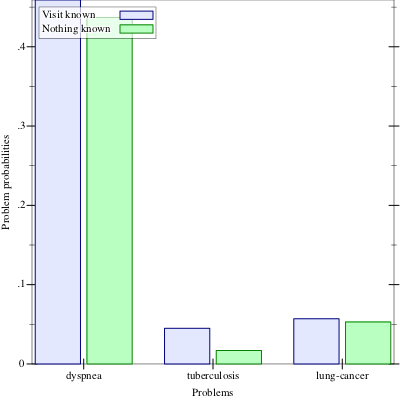

In [5]:
(require plot/pict)
(plot (list (discrete-histogram `(#(dyspnea ,(list-ref asia-w-visit-sample-means 0))
                                  #(tuberculosis ,(list-ref asia-w-visit-sample-means 1))
                                  #(lung-cancer ,(list-ref asia-w-visit-sample-means 2)))
                                    #:skip 2.5 
                                    #:x-min 0
                                    #:label "Visit known")
            (discrete-histogram `(#(dyspnea ,(list-ref asia-sample-means 0))
                                  #(tuberculosis ,(list-ref asia-sample-means 1))
                                  #(lung-cancer ,(list-ref asia-sample-means 2)))
                                    #:skip 2.5 
                                    #:x-min 1
                                    #:label "Nothing known"
                                    #:color 2
                                    #:line-color 2))
          #:x-label "Problems"
          #:y-label "Problem probabilities")



##...but inference is *usually **hard** *

Editing the model is not a very nice way to incorporate evidence, and not the way we'll usualy do it.  In fact, editing the program this way doesn't work at all for the obviously useful inference; the probability
that Bob has tuberculosis given that he
has some symptoms--say, an abnormal x-ray (though having recently made a trip to Asia 
might also be useful information--more on that later).  

We will write the probability of disease 
status $d$, given symtoms $s$, as 
$p(d|s)$.  We have defined a model in terms of
disease probability, $p(d)$ and symptom probability, given diseases $p(s|d)$. The program
represents a sequential generative process, where the conditions--the variables to the right of the "|"s--
are sampled before the variables to the left.  We can see now why 
editing the program fails: the program runs top to bottom (or inside to outside, for nested expressions), 
so fixing (rather than drawing) symptoms, 
which happen "later" in the generative process than diseases,
won't affect the frequency with which diseases are drawn.
This raises two questions: (1) How do we answer
the doctor's "backwards" question using this model? (2) Why didn't we just make the model go
the other way?  The short, vague answer to (2) is that sometimes we do, but that there are often good reasons not to. 
Let's postpone the details of when and why to make non-causally ordered models.


Mathematically, the answer to (1) is "simple": by the definition of conditional probability

$$p(d|s) = p(d,s)/p(s)$$

But neither of these probabilities is provided directly by the model. Instead, we have to consider
all the possible values of all the other variables.  For the moment, lets summarize such a value 
set as "n" (for "nuisance").

$$p(d|s) = \frac{\sum_n p(d,s,n)}{\sum_n p(s,n)}$$

The model tells us just how to decompose those joint probabilities into products of local 
conditionals.  

All of this leads to slogan two:

>**Probabilistic programs are written in programming languages that support *conditioning*. ** 



For simple, mathematically convenient models, there are closed-form solutions to some inference problems. But those are not those of most concern to us, because when domain experts construct models of systems, they aren't thinking about mathematical convenience.  


There are lots of other inference strategies and algorithms, several of which we will discuss.
But we discuss them only briefly, because one of the purposes
of a probabilistic programming language is to make it possible to think about models *without* at the 
same time thinking (much) about inference (this is not just for the benefit of the users of the language (the modelers); implementing inference algorithms case
by case is tiresome, repetitive, and error prone, so concentrating implementation and debugging effort into re-usable form benefits implementers, as well).

This is where probabilistic programming becomes clear as a new field, and not just an application
of existing programming languages.  Probabilistic programming aims to separate out the inference problem from
the model-specification problem, so that modelers need not know about inference algorithms
in order to get answers to their questions,
and so that inference methods and code can be reused across models, and efforts to validate and improve that
code can be consilidated and conserved.


>**We need probabilistic programming to allow us to think about modeling without at the same time having to think (much) about inference.**

For small, discrete-valued problems like the "Asia" BN, there are clever enumeration
algorithms for exact inference.  Approximate algorithms are more generally applicable.  We consider several inference algorithms, and show how to use them to specify observations and query the "Asia" BN. 

#Inference algorithms

##Inference by enumeration gives exact answers, when applicable

Instead of editing the model, the normal Gamble inference workflow specifies
* a *generative model* (the program that specifies the process), 
* some observations, and 
* a query expression. 

These three elements [go in to] an *inference method*.  Because the "Asia" Bayes net is small and discrete, we can solve it exactly, using 
"enumerate".  Enumerate considers all possible states of the non-observed variables, but does so in a clever
way that is much more efficient that brute-force enumeration. [equivalent to VE?]

TODO: do something to "results", below, to get individual variable probabilities, as I do for the 
other inferences.






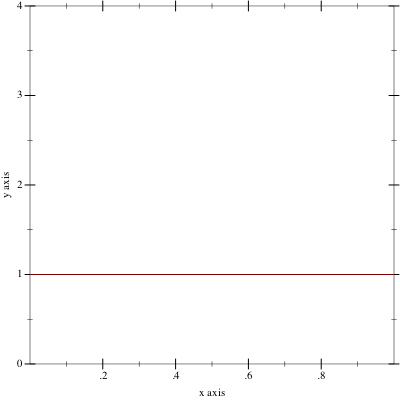

In [59]:
; A plotting convenience function
(define (show-beta alpha beta) 
  (plot (function 
         (lambda (x) (dist-pdf (beta-dist alpha beta) x)) 
         0.0001 
         0.9999 
         #:y-min 0
         #:y-max 4)))

(show-beta 1 1)

$beta(1,1)$ is just a uniform distribution on $[0,1]$.

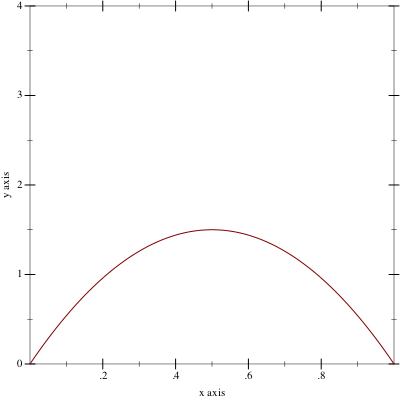

In [60]:
(show-beta 2 2)

Like $beta(1,1)$, $beta(2,2)$ favors neither side of the interval, but, unlike $beta(1,1)$, it concentrates its probability mass near 0.5.  In general, if the $\alpha$ and $\beta$ parameters are given equal values, larger values will concentrate more sharply on 0.5.

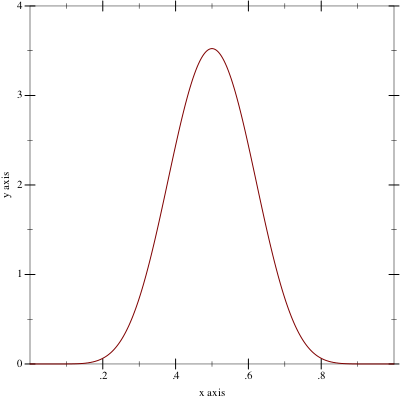

In [62]:
(show-beta 10 10)

When $\alpha$ is big, relative to $\beta$, the probability mass shifts towards 1.

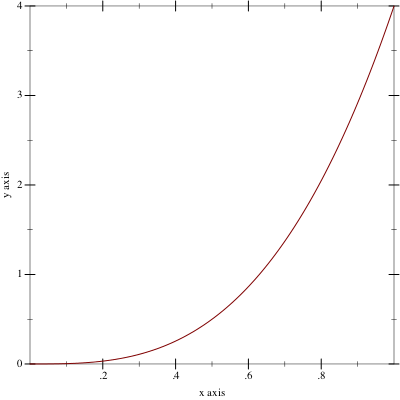

In [66]:
(show-beta 4 1)

Reversing the values of $\alpha$ and $\beta$ just flips the graph around the $x=0.5$ axis.

$\alpha$ and $\beta$ values below 1 concentrate probability mass near the extremes:

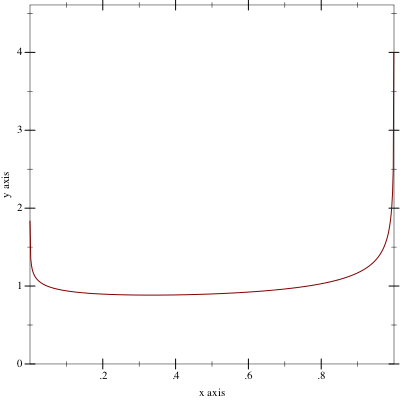

In [69]:
(show-beta 0.9 0.8)

Assuming a moderate concentration of probability mass near 0.5, we can model 5 flips of the same weighted coin like so:

In [75]:
(define weighted-flips
    (rejection-sampler
     
        ;; Generative model
        (define wt (beta 5 5))
        (deflazy result1 (bernoulli wt))
        (deflazy result2 (bernoulli wt))
        (deflazy result3 (bernoulli wt))
        (deflazy result4 (bernoulli wt))
        (deflazy result5 (bernoulli wt))
        (deflazy result6 (bernoulli wt))
     
        ;; Observations
        (observe result1 1)
        (observe result2 1)
        (observe result3 1)
        (observe result4 1)
        (observe result5 1)

        ;; Query expression
        (list wt (exact->inexact result6))))

   (sampler->mean weighted-flips 10000) 

(0.6665448617839016 0.6628000000000001)

Here we see that five 1s changes our best guess of the coin's weight to something like 0.67.

You probably noticed the new <code>deflazy</code> [constructs] where the defines used to be.  These are necessary because <code>observes</code> combine with sampling expressions, under the hood, whereas <code>define</code>s are evaluated immediately. [...Ryan...]

This happens to be one of those rare cases with a closed-form solution for the expected values of our query expressions.  The beta distribution is *conjugate* to the Bernoulli distribution, which means that the posterior distribution, given all of this observations, is also a beta distribution.  

Remember where I said that $\alpha$ and $\beta$ behave like pseudo-observations?  Well, observations do too!  To get the posterior beta, we just add the number of 1s to alpha to define $\alpha'$, and the number of 0s to $\beta$ to define $\beta'$.  The posterior is then $beta(\alpha',\beta')$--here, $beta(10,5)$.

A quick look at Wikipedia confirms that the mean of this posterior is $10/(10+5) = 2/3 \approx 0.66$, and the posterior predictive distribution of <code>result6</code> is the same.



[not budging enough after ten heads, leading to...]

[...more realistic, less mathematically convenient mixture distribution]

[...]


#Beyond BNs: indexed random variables

There is a regular structure to the previous program that should be annoying to every programmer: all of those "define resultN" statements look the same.  All of the variables defined in those statements are drawn from the same distribution.  Can't we put them in an indexed set, such as an array or hash?  A popular Gamble idiom (borrowed from Church, but cleaned up) does something a tiny bit more abstract; we use <code>defmem</code> to draw a random *function* from objects of whatever type (integers, below) to draws from <code>(bernoulli wt)</code>.  Conceptually, the entire (infinite) table of values is drawn at the time of definition, but the implementation is lazy; the random draw for a particular input to the random function is drawn the first time that input is seen, and memoized.  

[What would be the most natural way to say "draw me a function at random from the set of functions that assign to each object in the range a draw from dist"?]

In [70]:
;; Imports "range" and "for".
(require racket/list)

(define weighted-flips
   (rejection-sampler
   
    ;; Generative model
    (define wt (beta 5 5))
      (defmem (result flip-num)
        (bernoulli wt))
    
    ;; Observations
    (for ([x (range 1 6)])
          (observe (result x) 1))
    
    ;; Query expression
    (list wt (exact->inexact (result 6)))))

   (sampler->mean weighted-flips 10000) 

(0.6661860628194309 0.6676000000000001)

Metropolis-Hastings sampling also gets the right answer: (Hooray!)

(define weighted-flips-mh
   (mh-sampler
   
    ;; Generative model
    (define wt (beta 5 5))
      (defmem (result flip-num)
        (bernoulli wt))
    
    ;; Observations
    (for ([x (range 1 6)])
          (observe (result x) 1))
    
    ;; Query expression
    (list wt (exact->inexact (result 6)))))

   (sampler->mean weighted-flips-mh 1000 #:burn 1000 #:thin 50) 

[We have to track this down and fix it: adaptive-drift-proposal: scale increased out of range]

In [79]:
(expt 3 2)

9

In [83]:
(exact->inexact (expt (/ 51 49) 100))

54.62728380723642

#Junk


###Some inferences are easy...

The "Asia" model is typical of an intuitive, causal style of modeling. It defines a joint probability 
distribution over risk factors, diseases, and symptoms (that is, it defines the probability of every 
distinct set of values for those variables) by breaking
the process in to small pieces, and it does so in a certain direction.  The pieces correspond to hypothesized 
"causal mechanisms", about which you can read more here (link).  For instance, disease probabilities 
depend directly on risk factors, because risk factors cause diseases.  Similarly, symptom
probabilities depend directly on diseases, because diseases cause symptoms.  Risk factors also cause
symptoms, but only indirectly, via diseases.  



A model of this form makes it easy to make one kind of conditional inference: forward, from causes to effects 
(note: the Bayes net formalism doesn't require a causal ordering, and arrows should not always be
interpreted as causal.  What makes inference easy, in any Bayes net, is query variables that are 
*desendants* of observed ones, whether those descendants are effects or not).

Suppose we want to know the probability that Bob has tuberculosis, given that he has visited Asia.
All we have to do is modify the model above to fix the values of $\verb+visit-to-asia+$ to $\verb+#t+$.




## and more junk

So what?  You don't need the help of
probability theory or computers to answer questions about a single coin flip, or even the long-run average of many coin flips.  If you have a 
little bit of experience with such things, you can probably even answer simple *conditional* questions like "what's
the probability that the first of two flips was heads, given that at least one flip was heads.

[more code...]

WHERE?: In coin flipping, our ignorance of or inability to measure precisely enough the factors that determine the outcome is nearly complete, but for many other systems (e.g., the motion of a
projectile), we have pretty good deterministic models and measurements.  The probabilistic parts are there to capture
minor deviations from our ideal model caused by such nuisances as a changeable atmosphere and 
imperfect sensors.  Random elements sweep under the rug all the factors that either aren't worth 
modeling, because they complicate the model without much improving predictions; or about which we 
can never know very much.  

  
### Intuition and case enumeration fail
When processes get just a little more complex than a pair of coin flips, though, unaided human minds either 
* fail to compute or intuit an answer:
    * Q: If anywhere from one to six dice are selected, with equal probability, and the maximum across all dice, in one roll, is 5, what is the probability that the number of dice chosen is two?
    * A: I need a computer for this.  Or at least lots of paper and time.
* intuit wrong answers: 
    * Q: Are you having a hot streak at the roulette table?  
    * A: Yeah, Baby!  (wrong)

### Mathematical analysis fails
Sometimes we can use the
calculus of probability to answer questions our intution can't.  For instance, suppose ....

### Numerical approximations fail 
We can also use built-in programming language functions to predict the outcomes of more 
complicated processes,
such as flipping a coin 100 times and outputing 1 if heads occurs at least 70 times.  What is
the probability of this event? If you said "about 0.0000016", give yourself a gold star (or give one to the software that told you the answer).



Questions like that above (probability of 70+ heads in 100 fair coin flips) can be answered quickly, to a high degree of precision, by closed form math or fast, accurate numerical methods.  However, queries over more complex models have no such simple off-the-shelf solution methods. The progress of model development...[somewhere: Modeling the system under consideration--call it "s1"--is not the same thing as designing a system ("s2") to answer questions about s1.  s1 is usually what we care about, and s2 is what we have to muck with to get answers about s1. ]

[In these cases, writing down a model of the system you care about is only half (or a tenth of) the battle.  You also need to specify a method for getting an answer.]

Simulation is useful when mathematical analysis runs out of steam.


#Inference: why we need probabilistic programming

Making a model of how frequently diseases occur, and how often they 
produce various symptoms, is a fine exercise in formalization. First, write down a step-by-step
description of the process.  If it's too hard to do the math, or you are too lazy, then 
draw samples to get an estimate of how often it plays out this or that way.  Note, though,
that, so far, we haven't done 
anything we couldn't have done in just about any existing 
programming language.  


##Why do we need anything new?  
Mere simulation of a process is not enough, because **sampling from the possible executions of the process doesn't
solve the kinds of problems people usually want to solve**.  Usually, we *observe* the 
values of some random variables in the model, and want to *infer* the probable values 
of some others.  For example, a doctor
observes a patient's symptoms and needs to infer the patient's probable disease status. The doctor 
*knows* that the process played out is some way such that particular symptoms
occurred, and wants to know something else about how it played out--what *unobservable* disease happened
to cause the symptoms.


###Some inferences are easy...

The "Asia" model is typical of an intuitive, causal style of modeling. It defines a joint probability 
distribution over risk factors, diseases, and symptoms (that is, it defines the probability of every 
distinct set of values for those variables) by breaking
the process in to small pieces, and it does so in a certain direction.  The pieces correspond to hypothesized 
"causal mechanisms", about which you can read more here (link).  For instance, disease probabilities 
depend directly on risk factors, because risk factors cause diseases.  Similarly, symptom
probabilities depend directly on diseases, because diseases cause symptoms.  Risk factors also cause
symptoms, but only indirectly, via diseases.  



A model of this form makes it easy to make one kind of conditional inference: forward, from causes to effects 
(note: the Bayes net formalism doesn't require a causal ordering, and arrows should not always be
interpreted as causal.  What makes inference easy, in any Bayes net, is query variables that are 
*desendants* of observed ones, whether those descendants are effects or not).

Suppose we want to know the probability that Bob has tuberculosis, given that he has visited Asia.
All we have to do is modify the model above to fix the values of $\verb+visit-to-asia+$ to $\verb+#t+$.


##Simple rejection sampling implements the meaning of conditioning

The simplest approximation is this: run the program many times, and throw out those runs that don't 
produce Bob's symptoms. The proportion of retained runs in which tuberculosis is $\verb+#t+$ will be, on average,
$p(tuberculosis|cough,x-ray)$. 




<code></code>

Here we have 

* defined a program to 
  * draw a sample from the joint distribution, via a set of internal <code>defines</code>,
  * define an output value (<code>(map (lambda ...</code>), based on that sample;
* run that program 1000 times; and 
* displayed proportions of samples for which the three variables in the output expression take on the value <code>#t</code>.  

$\verb+asia+$ is a no-arg procedure (thunk) that draws a value for each random variable. 
<code>sampler->mean</code> is a convenience function that runs a sampling thunk a number of times and takes the element-wise means of the samples.


###Digression: visualizing results

One thing you will want to do quite often is *look at* probability distributions represented as set of samples.  Histograms are very useful for this.  For details, see the 
[plot](http://docs.racket-lang.org/plot/index.html?q=plot)
library, but this examples gives an idea of the basic syntax:

For some other small, special models, posterior distributions
have nice closed forms.  However, in the general case, these expressions involve very large sums and/or
unsolvable integrals, and the only feasible approaches are approximate.  The next few sections discuss a few *Monte Carlo* approximations.  These are approximations that represent the posterior distributions of interest by sets of samples drawn from those distributions.  The first--rejection sampling--is a direct embodiment of the meaning of conditioning.  It is impractical for real problems, but useful as a conceptual aid, and as a check on the correctness of implementations of more sophisiticated algorithms.  The second is the (currently) most popular all purpose sampling method.



Unfortunately, in many more complicated models nearly all runs will be 
rejected, because the observations are very improbable (in the case of continuous-valued observations, infinitely
so). So, while simple rejection sampling is an intuitive way to think about the meaning of conditional
inference, and sometimes a useful check on the correctness of implementations of other inference methods, it
is rarely used in practice.  

[Likelihood weighting]


##Metropolis-Hastings sampling is the Swiss army knife of inference

We solved the "Asia" diagnosis problem above using "enum".  We can also solve it approximately, 
using a general-purpose sampling algorithm:

In [73]:
(require plot/pict
         racket/draw)
(plot (discrete-histogram `(#(dyspnea ,(list-ref asia-sample-means 0))
                         #(tuberculosis ,(list-ref asia-sample-means 1))
                         #(lung-cancer ,(list-ref asia-sample-means 2))))
      #:x-label "problems"
      #:y-label "probabilities of problems")

asia-sample-means: undefined;
 cannot reference undefined identifier
  context...:
   /Applications/Racket v6.1.1/share/pkgs/sandbox-lib/racket/sandbox.rkt:475:0: call-with-custodian-shutdown
   /Applications/Racket v6.1.1/collects/racket/private/more-scheme.rkt:147:2: call-with-break-parameterization
   /Applications/Racket v6.1.1/share/pkgs/sandbox-lib/racket/sandbox.rkt:837:5: loop
